#### <center>Python code file Generated for CCA (Clinical Context Aware)  classification Model. </center>
#### <center> Author - Fakhare Alam </center>
#### <center> Author - Muhammad Afzal, PhD </center>
#### <center> Author - Khalid Mahmood Malik, PhD </center>

## Import Python Library

In [1]:
import io
#from Bio import Entrez, Medline
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import re
import collections
import pandas as pd
import numpy as np
from tqdm import tqdm
#tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,make_scorer,precision_score,recall_score,roc_auc_score,f1_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from bs4 import BeautifulSoup
from rouge import Rouge

import warnings
warnings.simplefilter("ignore", UserWarning)


Using TensorFlow backend.


# STEP -1

## A. Data COllection & Data Pre-processing

#### Parse medline 

In [ ]:
def search_medline(query):
    '''
    @ Author - Dr. Afzal
    '''
    Entrez.email = "afzalse@gmail.com"
    search = Entrez.esearch(db='pubmed', term=query, retmax = 1000, usehistory='y')
    handle = Entrez.read(search)
    
    try:
        return handle
    except Exception as e:
        raise IOError(str(e))
    finally:
        search.close()

In [ ]:
def fetch_rec(rec_id, entrez_handle):
    '''
    @ Author - Dr. Afzal
    '''
    fetch_handle = Entrez.efetch(db='pubmed', id = rec_id, rettype='Medline', retmode='text',
                                 webenv=entrez_handle['WebEnv'],query_key=entrez_handle['QueryKey'])
    #print(type(fetch_handle))
    rec = fetch_handle.read()
    #print(type(rec))
    
    return rec

In [ ]:
query = "(cerebral aneurysm ) and ( family history or hypertension or )"
rec_handler = search_medline(query)

#fetch_rec('31326520', rec_handler)

In [ ]:
def collect_data2 (query) :
    '''
    @ Author - Dr. Afzal
    '''
    
    count = 0
    fau = ""
    mh = ""
    j = 0
    rec_handler = search_medline(query)
    count = int(rec_handler["Count"])
    batch_size = 200
    
    df = pd.DataFrame(columns = ['PMID', 'Title', 'Abstract', 'MeSH', 'PubType', 'PubDate', 'Journal', 'DOI', 'PMC'])
    
    
           
    for recId in rec_handler['IdList']:
        #count = count+1
        fau = ""
        mh = ""

        rec = fetch_rec(recId, rec_handler)

        r = io.StringIO(rec)
        medline_rec = Medline.read(r)

        if 'PMID' in medline_rec:
            df.loc[j, 'PMID'] = medline_rec['PMID']

        if 'TI' in medline_rec:
            #df.assign(Title = lambda x: medline_rec['TI'])
            df.loc[j, 'Title'] = medline_rec['TI']
        else:
            df.loc[j, 'Title'] = 'null'

        if 'AB' in medline_rec:
            df.loc[j, 'Abstract'] = medline_rec['AB']
        else:
            df.loc[j, 'Abstract'] = 'null'

        if 'PT' in medline_rec:
            df.loc[j, 'PubType'] = medline_rec['PT']
        else:
            df.loc[j, 'PubType'] = 'null'

        if 'FAU' in medline_rec:
            for y in medline_rec['FAU']:
                fau = fau + y + ', '
            df.loc[j, 'FAU'] = fau
        else:
            df.loc[j, 'FAU'] = 'null'

        if 'MH' in medline_rec:
            for x in medline_rec['MH']:
                mh = mh + x + ', '
            df.loc[j, 'MeSH'] = mh
        else:
            df.loc[j, 'MeSH'] = 'null'

        if 'DP' in medline_rec:
            df.loc[j, 'PubDate'] = medline_rec['DP']
        else:
            df.loc[j, 'PubDate'] = 'null'

        if 'JT' in medline_rec:
            df.loc[j, 'Journal'] = medline_rec['JT']
        else:
            df.loc[j, 'Journal'] = 'null'

        if 'AID' in medline_rec:
            df.loc[j, 'DOI'] = medline_rec['AID']
        else:
            df.loc[j, 'DOI'] = 'null'

        if 'PMC' in medline_rec:
            df.loc[j, 'PMC'] = medline_rec['PMC']
        else:
            df.loc[j, 'PMC'] = 'null'

        mh = ""
        fau = ""

        print(j)
        j = j + 1
        #rec.close()

    #print(df.head())
    df.to_excel('Medline.xlsx')
    return count

In [ ]:
#q = "brain aneurysm or cerebral aneurysm or intracranial aneurysm"
q = "cerebral aneurysm and family history"
count = collect_data2(q)


#### Sblit Abstract - Not needed any more

In [ ]:
def splitAbstract(cols):
    '''
    @Author - Fakhare Alam
    This method splits abstract
    '''
    abstract = cols[0]
    if pd.isnull(abstract):
        return 'NA'
    else:
        return abstract.split(':')[0]
    
#df_raw['Abstract_split'] = df_raw[['Abstract']].apply(splitAbstract,axis=1)


#### Read Excel file

In [ ]:
df_raw=pd.read_excel('Medline_new.xlsx')

#### Append end: at the end of the file

In [ ]:
def appendAbstract(cols):
    '''
    @Author - Fakhare Alam
    This method appends all abstract.
    '''
    abstract = cols[0]
    if pd.isnull(abstract):
        return 'NA'
    else:
        return abstract+'end:'
    
df_raw['Abstract'] = df_raw[['Abstract']].apply(appendAbstract,axis=1)

#### Define master list for different categories

##### This is master list of all the categories

In [ ]:
master_cat_list=['objective:', 'background:', 'background and objectives:', 'context:', 'background and purpose:',
                 'purpose:', 'importance:', 'introduction:', 'aim:', 'rationale:', 'goal:', 'context:', 'hypothesis:'
                ,'population:', 'participant:', 'sample:', 'subject:', 'patient:','patient 2:','patient 1:',
                 'intervension:', 'diagnosis:'
                ,'outcome:', 'measure:', 'variable:', 'assessment:'
                ,'method:','methods:' ,'setting:', 'design:', 'material:', 'procedure:', 'process:', 'methodology:'
                ,'result:','results:','finding:',
                 'conclusion:','conclusions:', 'implication:', 'discussion:', 'interpretation table:','end:']

Headings = {'A': ['objective:', 'background:', 'background and objectives:', 'context:', 'background and purpose:','purpose:', 'importance:', 'introduction:', 'aim:', 'rationale:', 'goal:', 'context:', 'hypothesis:'],
            'P': ['population:', 'participant:', 'sample:', 'subject:', 'patient:','patient 2:','patient 1:'],
            'I': ['intervension:', 'diagnosis:'],
            'O': ['outcome:', 'measure:', 'variable:', 'assessment:'],
            'M': ['method:','methods:' ,'setting:', 'design:', 'material:', 'procedure:', 'process:', 'methodology:'],
            'R': ['result:','results:','finding:'],
            'C': ['conclusion:','conclusions:', 'implication:', 'discussion:', 'interpretation table:']}

#### Looping to find keyword in each abstract

In [ ]:
def abstractCatList(cols):
    abstract=cols['Abstract']
    abstract_cat_list={}
    for cat in master_cat_list:
        indexpos=abstract.lower().find(cat.lower())
        if (indexpos!=-1):
            abstract_cat_list[indexpos]=cat
    return abstract_cat_list

df_raw['Abstract_Cat_List'] = df_raw[['Abstract']].apply(abstractCatList,axis=1)    

#### Create new dataframe with filled column

In [ ]:

df_raw_split=pd.DataFrame(columns=df_raw.columns)

for index, row in df_raw.iterrows():
    #print(row('Abstract'))
    od = collections.OrderedDict(sorted(row['Abstract_Cat_List'].items()))
    key_list=list(od.keys())
    s=row['Abstract'].lower()
    for i in range(0,len(key_list)-1,1):
        try:
            start=row['Abstract_Cat_List'][key_list[i]]
            end=row['Abstract_Cat_List'][key_list[i+1]]
            result = re.search('%s(.*)%s' % (start, end), s).group(1)
            row[start]=result
        except:
            continue
    df_raw_split=df_raw_split.append(row,ignore_index=True)
     
        

In [ ]:
df[['Year', 'quarter']].apply(lambda x: ''.join(x), axis=1)
Headings = {'A': ['objective:', 'background:', 'background and objectives:', 'context:', 'background and purpose:','purpose:', 'importance:', 'introduction:', 'aim:', 'rationale:', 'goal:', 'context:', 'hypothesis:'],
            'P': ['population:', 'participant:', 'sample:', 'subject:', 'patient:','patient 2:','patient 1:'],
            'I': ['intervension:', 'diagnosis:'],
            'O': ['outcome:', 'measure:', 'variable:', 'assessment:'],
            'M': ['method:','methods:' ,'setting:', 'design:', 'material:', 'procedure:', 'process:', 'methodology:'],
            'R': ['result:','results:','finding:'],
            'C': ['conclusion:','conclusions:', 'implication:', 'discussion:', 'interpretation table:']}

In [ ]:
A=['objective:', 'background:', 'background and objectives:', 'context:', 'background and purpose:','purpose:', 'importance:', 'introduction:', 'aim:', 'rationale:', 'goal:', 'context:', 'hypothesis:']
df_raw_split['|a|']=df_raw_split[A].apply(lambda x: ''.join(x), axis=1)

P=['population:', 'participant:', 'sample:', 'subject:', 'patient:','patient 2:','patient 1:']
df_raw_split['|p|']=df_raw_split[P].apply(lambda x: ''.join(x), axis=1)

I=['intervension:', 'diagnosis:']
df_raw_split['|i|']=df_raw_split[I].apply(lambda x: ''.join(x), axis=1)

O=['outcome:', 'measure:', 'variable:', 'assessment:']
df_raw_split['|o|']=df_raw_split[O].apply(lambda x: ''.join(x), axis=1)

M=['method:','methods:' ,'setting:', 'design:', 'material:', 'procedure:', 'process:', 'methodology:']
df_raw_split['|m|']=df_raw_split[M].apply(lambda x: ''.join(x), axis=1)

R=['result:','results:','finding:']
df_raw_split['|r|']=df_raw_split[R].apply(lambda x: ''.join(x), axis=1)

C=['conclusion:','conclusions:', 'implication:', 'discussion:', 'interpretation table:']
df_raw_split['|c|']=df_raw_split[C].apply(lambda x: ''.join(x), axis=1)

In [ ]:
aimoprc_list=['|a|', '|i|', '|m|', '|o|','|p|', '|r|', '|c|']
# Test
df_pubmed_final=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
for aimoprc in aimoprc_list:
    df_temp_pubmed=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
    df_temp_pubmed['sent']=df_raw_split[aimoprc]
    df_temp_pubmed['aimoprc_category']=aimoprc
    df_temp_pubmed['data_category']='medline'
    df_pubmed_final=df_pubmed_final.append(df_temp_pubmed)

In [ ]:
df_pubmed_final.replace('', np.nan, inplace=True)
df_pubmed_final.dropna(inplace=True)

#### Write to new file

In [ ]:
df_pubmed_final.to_csv('medline_parsed.csv')

#### Parse BioNLP PICO File

In [ ]:
Bionlp_master_cat_list=['|a|','|p|','|i|','|o|','|m|','|r|','|c|','|e|']

In [ ]:
with open("PICO_test.txt", "r") as picoFile:
    picoFileTest=picoFile.read()    
    
with open("PICO_train.txt", "r") as picoFile:
    picoFileTrain=picoFile.read()    
    
with open("PICO_dev.txt", "r") as picoFile:
    picoFileDev=picoFile.read()    

In [ ]:
## Test
dict_bionlp_test={}
pubidListTest=re.split('[0-9]:\s|\s{2,}', picoFileTest)

for i in range(0,len(pubidListTest)-1,2):
    dict_bionlp_test[pubidListTest[i]]=pubidListTest[i+1]

## Train
dict_bionlp_train={}
pubidListTrain=re.split('[0-9]:\s|\s{2,}', picoFileTrain)

for i in range(0,len(pubidListTrain)-1,2):
    dict_bionlp_train[pubidListTrain[i]]=pubidListTrain[i+1]
    
    
## Dev
dict_bionlp_dev={}
pubidListDev=re.split('[0-9]:\s|\s{2,}', picoFileDev)

for i in range(0,len(pubidListDev)-1,2):
    dict_bionlp_dev[pubidListDev[i]]=pubidListDev[i+1]

In [ ]:
df_bionlp_test=pd.DataFrame(list(dict_bionlp_test.items()),columns=['pubid','Abstract'])
df_bionlp_train=pd.DataFrame(list(dict_bionlp_train.items()),columns=['pubid','Abstract'])
df_bionlp_dev=pd.DataFrame(list(dict_bionlp_dev.items()),columns=['pubid','Abstract'])

In [ ]:
def bioNLPappendAbstract(cols):
    '''
    @Author - Fakhare Alam
    '''
    abstract = cols[0]
    if pd.isnull(abstract):
        return 'NA'
    else:
        return abstract+'|e|'
    
df_bionlp_test['Abstract'] = df_bionlp_test[['Abstract']].apply(bioNLPappendAbstract,axis=1)
df_bionlp_train['Abstract'] = df_bionlp_train[['Abstract']].apply(bioNLPappendAbstract,axis=1)
df_bionlp_dev['Abstract'] = df_bionlp_dev[['Abstract']].apply(bioNLPappendAbstract,axis=1)

In [ ]:
def bioNLPabstractCatList(cols):
    '''
    @Author - Fakhare Alam
    '''
    abstract=cols['Abstract']
    abstract_cat_list={}
    for cat in Bionlp_master_cat_list:
        indexpos=abstract.lower().find(cat.lower())
        if (indexpos!=-1):
            abstract_cat_list[indexpos]=cat
    return abstract_cat_list

df_bionlp_test['Abstract_Cat_List'] = df_bionlp_test[['Abstract']].apply(bioNLPabstractCatList,axis=1) 
df_bionlp_train['Abstract_Cat_List'] = df_bionlp_train[['Abstract']].apply(bioNLPabstractCatList,axis=1) 
df_bionlp_dev['Abstract_Cat_List'] = df_bionlp_dev[['Abstract']].apply(bioNLPabstractCatList,axis=1) 

In [ ]:
df_bionlp_test_split=pd.DataFrame(columns=df_bionlp_test.columns)
df_bionlp_train_split=pd.DataFrame(columns=df_bionlp_train.columns)
df_bionlp_dev_split=pd.DataFrame(columns=df_bionlp_dev.columns)

# Test
for index, row in df_bionlp_test.iterrows():
    od = collections.OrderedDict(sorted(row['Abstract_Cat_List'].items()))
    key_list=list(od.keys())
    s=row['Abstract'].lower()
    row['pubid']=row['pubid'][3:]
    for i in range(0,len(key_list),1):
        try:
            start=row['Abstract_Cat_List'][key_list[i]]
            row[start]=s[key_list[i]:key_list[i+1]]
        except:
            continue
    df_bionlp_test_split=df_bionlp_test_split.append(row,ignore_index=True)


    
# Train
for index, row in df_bionlp_train.iterrows():
    od = collections.OrderedDict(sorted(row['Abstract_Cat_List'].items()))
    key_list=list(od.keys())
    s=row['Abstract'].lower()
    row['pubid']=row['pubid'][3:]
    for i in range(0,len(key_list),1):
        try:
            start=row['Abstract_Cat_List'][key_list[i]]
            row[start]=s[key_list[i]:key_list[i+1]]
        except:
            continue
    df_bionlp_train_split=df_bionlp_train_split.append(row,ignore_index=True)

# Dev
for index, row in df_bionlp_dev.iterrows():
    od = collections.OrderedDict(sorted(row['Abstract_Cat_List'].items()))
    key_list=list(od.keys())
    s=row['Abstract'].lower()
    row['pubid']=row['pubid'][3:]
    for i in range(0,len(key_list),1):
        try:
            start=row['Abstract_Cat_List'][key_list[i]]
            row[start]=s[key_list[i]:key_list[i+1]]
        except:
            continue
    df_bionlp_dev_split=df_bionlp_dev_split.append(row,ignore_index=True)
    
   

In [ ]:
aimoprc_list=['|a|', '|i|', '|m|', '|o|','|p|', '|r|', '|c|']
# Test
df_bionlp_final_test=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
for aimoprc in aimoprc_list:
    df_temp_test=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
    df_temp_test['sent']=df_bionlp_test_split[aimoprc]
    df_temp_test['aimoprc_category']=aimoprc
    df_temp_test['data_category']='PICO_test'
    df_bionlp_final_test=df_bionlp_final_test.append(df_temp_test)

# Train
df_bionlp_final_train=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
for aimoprc in aimoprc_list:
    df_temp_train=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
    df_temp_train['sent']=df_bionlp_train_split[aimoprc]
    df_temp_train['aimoprc_category']=aimoprc
    df_temp_train['data_category']='PICO_train'
    df_bionlp_final_train=df_bionlp_final_train.append(df_temp_train)
    
df_bionlp_final_dev=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
for aimoprc in aimoprc_list:
    df_temp_dev=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
    df_temp_dev['sent']=df_bionlp_dev_split[aimoprc]
    df_temp_dev['aimoprc_category']=aimoprc
    df_temp_dev['data_category']='PICO_dev'
    df_bionlp_final_dev=df_bionlp_final_dev.append(df_temp_dev)
    

In [ ]:
df_bionlp_final=pd.DataFrame(columns=['sent','aimoprc_category','data_category'])
df_bionlp_final=df_bionlp_final.append(df_bionlp_final_test).append(df_bionlp_final_train).append(df_bionlp_final_dev)

In [ ]:
## rEPLACE a,I ,M,O,P,R,C
#['|a|', '|i|', '|m|', '|o|','|p|', '|r|', '|c|']
def replaceColumnKeyword(cols):
    '''
    @Author - Fakhare Alam
    '''
    sent = cols[0]
    if pd.isnull(sent):
        return ''
    else:
        sent=sent.replace('|a|','').replace('|i|','').replace('|m|','').replace('|o|','').replace('|p|','').replace('|r|','').replace('|c|','')
        if(len(sent.rsplit(' ', 1))>1):
            remWord=sent.rsplit(' ', 1)[1]
            if (remWord in [x.split(":")[0] for x in master_cat_list]):
                sent=sent.rsplit(' ', 1)[0]
        return sent
    
df_bionlp_final['sent'] = df_bionlp_final[['sent']].apply(replaceColumnKeyword,axis=1)

In [ ]:
df_bionlp_final.to_csv('bionlp.csv')

#### Merge Both Bionlp and medline text


In [ ]:
df_final=df_pubmed_final.append(df_bionlp_final)

In [ ]:
df_final['aimoprc_category']=df_final['aimoprc_category'].map({'|a|':'A', '|i|':'I', '|m|':'M', '|o|':'O','|p|':'P', '|r|':'R', '|c|':'C'})


In [ ]:
df_final.to_csv('FinalParsed.csv')
# This is the file after all the parsing

# STEP -2

#### Read from final file -- DO NOT TOUCH Commented purposefully

##### Generated after all the pre-processing and merger of  certain category

In [ ]:
'''

df_final=pd.read_csv('FinalParsed.csv')
rulesCO = {'C':'O'}
# Merge {M,P},{C,O}
df_final['aimoprc_category'].replace(rulesCO,inplace=True)
rulesMP = {'M':'P'}
df_final['aimoprc_category'].replace(rulesMP,inplace=True)

# Drop NULL Sentences
df_final.dropna(axis=0,how='any',inplace=True)
df_final.to_csv('FinalParsed_cleaned.csv')
'''
A->P->I->R-O

#### Read from final file  generated earlier

In [3]:
df_final=pd.read_csv('APIRO_Datset.csv')

In [4]:
df_final['aimoprc_category'].value_counts()

O    50079
P    49324
A    31696
R    30589
I    11713
Name: aimoprc_category, dtype: int64

In [5]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173401 entries, 0 to 173400
Data columns (total 5 columns):
Unnamed: 0          173401 non-null int64
Unnamed: 0.1        173401 non-null int64
sent                173401 non-null object
aimoprc_category    173401 non-null object
data_category       173401 non-null object
dtypes: int64(2), object(3)
memory usage: 6.6+ MB


## STEP-3 Bi-LSTM Classification Model using Keras 

#### Uncomment to Load All the trained Model

In [8]:
'''
logreg_K =pickle.load(open('logreg_K', 'rb'))
knn_K =pickle.load(open('knn_K', 'rb'))
adaboost_b_K =pickle.load(open('adaboost_b_K', 'rb'))
Gboost_b_K=pickle.load(open('Gboost_b_K', 'rb'))
mlp_K =pickle.load(open('ANN_word2vec_K', 'rb'))
model=pickle.load(open('LSTM_model_keras.sav', 'rb'))
'''


#### Data Preprocessing step

In [9]:
df_final = df_final.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_final['sent'] = df_final['sent'].apply(clean_text)

df_final['sent'] =df_final['sent'].str.replace('\d+', '')

#The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_final['sent'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df_final['sent'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = df_final['aimoprc_category']
Y_L = pd.get_dummies(df_final['aimoprc_category']).values
print('Shape of label tensor:', Y.shape)

X_train_K, X_test_K, Y_train_K, Y_test_K = train_test_split(X,Y, test_size = 0.10, random_state = 42)

X_train_K_LSTM, X_test_K_LSTM, Y_train_K_LSTM, Y_test_K_LSTM = train_test_split(X,Y_L, test_size = 0.10, random_state = 42)

print(X_train_K.shape,Y_train_K.shape)
print(X_test_K.shape,Y_test_K.shape)

Found 99611 unique tokens.
Shape of data tensor: (173401, 250)
Shape of label tensor: (173401,)
(156060, 250) (156060,)
(17341, 250) (17341,)


#### Model 1- Logistic Regression- Keras

In [69]:
# Comment two lines When trained model is loaded
logreg_K=LogisticRegression()
logreg_K.fit(X_train_K, Y_train_K)
Y_pred_K=logreg_K.predict(X_test_K)
print(confusion_matrix(Y_test_K,Y_pred_K))
print(classification_report(Y_test_K,Y_pred_K))
print('Logistic Regression Keras-Accuracy' ,accuracy_score(Y_test_K,Y_pred_K))

[[  11    0 2050  662  410]
 [   1    0  792  332  113]
 [  13    0 3662  958  403]
 [  71    0 2266 1950  565]
 [  24    0 1098  373 1587]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           A       0.09      0.00      0.01      3133
           I       0.00      0.00      0.00      1238
           O       0.37      0.73      0.49      5036
           P       0.46      0.40      0.43      4852
           R       0.52      0.51      0.52      3082

    accuracy                           0.42     17341
   macro avg       0.29      0.33      0.29     17341
weighted avg       0.34      0.42      0.36     17341

Logistic Regression Keras-Accuracy 0.4157776368144859


#### Model 2- KNN -Keras

In [71]:
# Comment two lines When trained model is loaded
knn_K = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_K.fit(X_train_K, Y_train_K)
Y_pred_K=knn_K.predict(X_test_K)
print(confusion_matrix(Y_test_K,Y_pred_K))
print(classification_report(Y_test_K,Y_pred_K))
print('Accuracy' ,accuracy_score(Y_test_K,Y_pred_K))

[[ 801  109 1261  701  261]
 [ 275   95  458  337   73]
 [1186  196 2205 1152  297]
 [ 857  177 1418 2057  343]
 [ 579   74  966  532  931]]
              precision    recall  f1-score   support

           A       0.22      0.26      0.23      3133
           I       0.15      0.08      0.10      1238
           O       0.35      0.44      0.39      5036
           P       0.43      0.42      0.43      4852
           R       0.49      0.30      0.37      3082

    accuracy                           0.35     17341
   macro avg       0.33      0.30      0.30     17341
weighted avg       0.36      0.35      0.35     17341

Accuracy 0.35113315264402284


#### Model 3-AdaBoost -Keras

In [58]:
# Comment two lines When trained model is loaded
adaboost_b_K = AdaBoostClassifier(random_state=1)
adaboost_b_K.fit(X_train_K, Y_train_K)
Y_pred_K = adaboost_b_K.predict(X_test_K)
print(confusion_matrix(Y_test_K,Y_pred_K))
print(classification_report(Y_test_K,Y_pred_K))
print('AdaBoost Keras- Accuracy' ,accuracy_score(Y_test_K,Y_pred_K))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

[[ 213   11 1980  521  408]
 [   8  507  199  464   60]
 [ 214   47 3284 1052  439]
 [ 126  249 1457 2378  642]
 [ 148    0  607  150 2177]]
              precision    recall  f1-score   support

           A       0.30      0.07      0.11      3133
           I       0.62      0.41      0.49      1238
           O       0.44      0.65      0.52      5036
           P       0.52      0.49      0.51      4852
           R       0.58      0.71      0.64      3082

    accuracy                           0.49     17341
   macro avg       0.49      0.47      0.45     17341
weighted avg       0.48      0.49      0.46     17341

AdaBoost Keras- Accuracy 0.49357015166368723


#### Model 4- Gradient Boost -Keras

In [59]:
# Comment two lines When trained model is loaded
Gboost_b_K = GradientBoostingClassifier(learning_rate=0.01,random_state=1)
Gboost_b_K.fit(X_train_K, Y_train_K)
Y_pred_K = Gboost_b_K.predict(X_test_K)
print(confusion_matrix(Y_test_K,Y_pred_K))
print(classification_report(Y_test_K,Y_pred_K))
print(' Gradient Boost - Keras Accuracy' ,accuracy_score(Y_test_K,Y_pred_K))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[[  19   15 2190  436  473]
 [   0  701  230  249   58]
 [   1   93 3679  813  450]
 [   1  321 1742 2159  629]
 [   0    3  800  128 2151]]
              precision    recall  f1-score   support

           A       0.90      0.01      0.01      3133
           I       0.62      0.57      0.59      1238
           O       0.43      0.73      0.54      5036
           P       0.57      0.44      0.50      4852
           R       0.57      0.70      0.63      3082

    accuracy                           0.50     17341
   macro avg       0.62      0.49      0.45     17341
weighted avg       0.59      0.50      0.45     17341

 Gradient Boost - Keras Accuracy 0.5022201718470677


#### Model 5-ANN 

In [60]:
# Comment two lines When trained model is loaded
mlp_K = MLPClassifier(hidden_layer_sizes=(100, 70, 30,20,10), max_iter=1000)
mlp_K.fit(X_train_K, Y_train_K)
Y_pred_K = mlp_K.predict(X_test_K)
print(confusion_matrix(Y_test_K,Y_pred_K))
print(classification_report(Y_test_K,Y_pred_K))
print('ANN - Keras Accuracy' ,accuracy_score(Y_test_K,Y_pred_K))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 70, 30, 20, 10),
              learning_rate='constant', learning_rate_init=0.001, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

[[   0    0 3133    0    0]
 [   0    0 1237    1    0]
 [   0    0 5036    0    0]
 [   0    0 4852    0    0]
 [   0    0 3082    0    0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           A       0.00      0.00      0.00      3133
           I       0.00      0.00      0.00      1238
           O       0.29      1.00      0.45      5036
           P       0.00      0.00      0.00      4852
           R       0.00      0.00      0.00      3082

    accuracy                           0.29     17341
   macro avg       0.06      0.20      0.09     17341
weighted avg       0.08      0.29      0.13     17341

ANN - Keras Accuracy 0.2904100109566922


#### Model -6  Bi-directional Long Short Term Memory (Bi-LSTM) - Keras

In [ ]:
#df_final=pd.read_csv('FinalParsed_cleaned.csv')
df_final=df_final[[ 'sent', 'aimoprc_category']]

In [76]:
df_final.head()

,Unnamed: 0,Unnamed: 0.1,sent,aimoprc_category,data_category,cleaned_sent
0,0,1,innominate artery aneurysms iaas relatively ra...,A,medline,innominate artery aneurysms (iaas) are relati...
1,1,2,treating intracranial aneurysms open microsurg...,A,medline,when treating intracranial aneurysms with ope...
2,2,3,report novel internal eternal blood bypass met...,A,medline,to report a novel internal and eternal blood ...
3,3,5,imagebased hemodynamic simulations great poten...,A,medline,image-based hemodynamic simulations have grea...
4,4,7,intracranial aneurysm rupture devastating comp...,A,medline,intracranial aneurysm rupture is the most dev...


In [77]:
df_final['aimoprc_category'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of text', 
                                                                title='Number text in each category')

#### LSTM- Model Building

In [61]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


#### Training LSTM Model

In [62]:
epochs = 5
batch_size = 64

history = model.fit(X_train_K_LSTM, Y_train_K_LSTM, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 140454 samples, validate on 15606 samples
Epoch 1/5
 11264/140454 [=>............................] - ETA: 56:49 - loss: 1.6097 - accuracy: 0.171 - ETA: 47:09 - loss: 1.6067 - accuracy: 0.250 - ETA: 41:20 - loss: 1.6043 - accuracy: 0.307 - ETA: 37:02 - loss: 1.6014 - accuracy: 0.308 - ETA: 34:31 - loss: 1.5987 - accuracy: 0.321 - ETA: 32:58 - loss: 1.5972 - accuracy: 0.320 - ETA: 31:54 - loss: 1.5947 - accuracy: 0.310 - ETA: 30:48 - loss: 1.5908 - accuracy: 0.306 - ETA: 29:53 - loss: 1.5853 - accuracy: 0.300 - ETA: 29:05 - loss: 1.5806 - accuracy: 0.298 - ETA: 28:27 - loss: 1.5774 - accuracy: 0.295 - ETA: 27:58 - loss: 1.5718 - accuracy: 0.290 - ETA: 27:26 - loss: 1.5568 - accuracy: 0.295 - ETA: 27:05 - loss: 1.5514 - accuracy: 0.295 - ETA: 26:47 - loss: 1.5449 - accuracy: 0.297 - ETA: 26:28 - loss: 1.5405 - accuracy: 0.304 - ETA: 26:09 - loss: 1.5380 - accuracy: 0.305 - ETA: 25:53 - loss: 1.5364 - accuracy: 0.301 - ETA: 25:40 - loss: 1.5309 - accuracy: 0.305 - ETA: 25:28 - los

 11392/140454 [=>............................] - ETA: 21:04 - loss: 0.2809 - accuracy: 0.937 - ETA: 21:45 - loss: 0.3215 - accuracy: 0.921 - ETA: 21:25 - loss: 0.2760 - accuracy: 0.927 - ETA: 21:39 - loss: 0.2752 - accuracy: 0.921 - ETA: 21:20 - loss: 0.2713 - accuracy: 0.918 - ETA: 21:27 - loss: 0.2648 - accuracy: 0.919 - ETA: 21:29 - loss: 0.2768 - accuracy: 0.912 - ETA: 21:47 - loss: 0.2866 - accuracy: 0.910 - ETA: 21:53 - loss: 0.2866 - accuracy: 0.906 - ETA: 21:55 - loss: 0.2853 - accuracy: 0.907 - ETA: 21:58 - loss: 0.2839 - accuracy: 0.904 - ETA: 21:57 - loss: 0.2911 - accuracy: 0.902 - ETA: 22:03 - loss: 0.2912 - accuracy: 0.902 - ETA: 22:03 - loss: 0.2847 - accuracy: 0.904 - ETA: 22:07 - loss: 0.2703 - accuracy: 0.909 - ETA: 22:08 - loss: 0.2675 - accuracy: 0.909 - ETA: 22:10 - loss: 0.2656 - accuracy: 0.911 - ETA: 22:12 - loss: 0.2571 - accuracy: 0.914 - ETA: 22:10 - loss: 0.2548 - accuracy: 0.913 - ETA: 22:08 - loss: 0.2549 - accuracy: 0.914 - ETA: 22:12 - loss: 0.2510 - acc

140454/140454 [==============================] - ETA: 9s - loss: 0.1940 - accuracy: 0.937 - ETA: 8s - loss: 0.1939 - accuracy: 0.93 - ETA: 8s - loss: 0.1939 - accuracy: 0.93 - ETA: 7s - loss: 0.1939 - accuracy: 0.93 - ETA: 7s - loss: 0.1939 - accuracy: 0.93 - ETA: 6s - loss: 0.1939 - accuracy: 0.93 - ETA: 5s - loss: 0.1939 - accuracy: 0.93 - ETA: 5s - loss: 0.1939 - accuracy: 0.93 - ETA: 4s - loss: 0.1938 - accuracy: 0.93 - ETA: 4s - loss: 0.1939 - accuracy: 0.93 - ETA: 3s - loss: 0.1939 - accuracy: 0.93 - ETA: 2s - loss: 0.1939 - accuracy: 0.93 - ETA: 2s - loss: 0.1938 - accuracy: 0.93 - ETA: 1s - loss: 0.1939 - accuracy: 0.93 - ETA: 0s - loss: 0.1939 - accuracy: 0.93 - ETA: 0s - loss: 0.1938 - accuracy: 0.93 - 1361s 10ms/step - loss: 0.1938 - accuracy: 0.9373 - val_loss: 0.2071 - val_accuracy: 0.9339
Epoch 3/5
 11392/140454 [=>............................] - ETA: 25:51 - loss: 0.0863 - accuracy: 0.984 - ETA: 26:07 - loss: 0.0654 - accuracy: 0.992 - ETA: 24:58 - loss: 0.1418 - accurac

 11392/140454 [=>............................] - ETA: 23:04 - loss: 0.0504 - accuracy: 0.968 - ETA: 22:22 - loss: 0.0678 - accuracy: 0.968 - ETA: 21:59 - loss: 0.0538 - accuracy: 0.979 - ETA: 21:32 - loss: 0.0686 - accuracy: 0.976 - ETA: 21:34 - loss: 0.0755 - accuracy: 0.975 - ETA: 21:36 - loss: 0.0699 - accuracy: 0.976 - ETA: 21:43 - loss: 0.0623 - accuracy: 0.979 - ETA: 21:44 - loss: 0.0681 - accuracy: 0.978 - ETA: 21:51 - loss: 0.0672 - accuracy: 0.977 - ETA: 21:47 - loss: 0.0656 - accuracy: 0.979 - ETA: 21:44 - loss: 0.0707 - accuracy: 0.978 - ETA: 21:35 - loss: 0.0713 - accuracy: 0.979 - ETA: 21:32 - loss: 0.0669 - accuracy: 0.980 - ETA: 21:30 - loss: 0.0746 - accuracy: 0.976 - ETA: 21:32 - loss: 0.0731 - accuracy: 0.978 - ETA: 21:36 - loss: 0.0709 - accuracy: 0.979 - ETA: 21:38 - loss: 0.0770 - accuracy: 0.977 - ETA: 21:41 - loss: 0.0741 - accuracy: 0.979 - ETA: 21:37 - loss: 0.0732 - accuracy: 0.979 - ETA: 21:32 - loss: 0.0710 - accuracy: 0.980 - ETA: 21:30 - loss: 0.0708 - acc

140454/140454 [==============================] - ETA: 10s - loss: 0.0921 - accuracy: 0.970 - ETA: 9s - loss: 0.0921 - accuracy: 0.970 - ETA: 8s - loss: 0.0921 - accuracy: 0.97 - ETA: 8s - loss: 0.0921 - accuracy: 0.97 - ETA: 7s - loss: 0.0922 - accuracy: 0.97 - ETA: 7s - loss: 0.0922 - accuracy: 0.97 - ETA: 6s - loss: 0.0922 - accuracy: 0.97 - ETA: 5s - loss: 0.0922 - accuracy: 0.97 - ETA: 5s - loss: 0.0922 - accuracy: 0.97 - ETA: 4s - loss: 0.0922 - accuracy: 0.97 - ETA: 4s - loss: 0.0922 - accuracy: 0.97 - ETA: 3s - loss: 0.0922 - accuracy: 0.97 - ETA: 2s - loss: 0.0922 - accuracy: 0.97 - ETA: 2s - loss: 0.0922 - accuracy: 0.97 - ETA: 1s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - 1380s 10ms/step - loss: 0.0922 - accuracy: 0.9708 - val_loss: 0.2074 - val_accuracy: 0.9360
Epoch 5/5
 11392/140454 [=>............................] - ETA: 28:24 - loss: 0.0677 - accuracy: 0.984 - ETA: 29:28 - loss: 0.0946 - accuracy:

#### Testing LSTM-Model

In [48]:
accr = model.evaluate(X_test_K_LSTM,Y_test_K_LSTM)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17341/17341 [==============================] - ETA: 4: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 56 - ETA: 54 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ET

#### Test Loss Historyc LSTM-Model

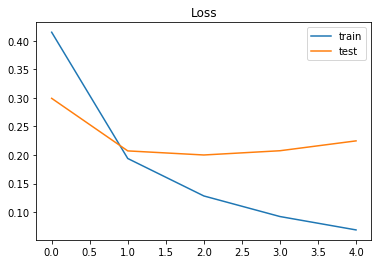

In [64]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

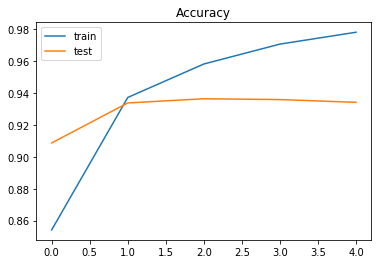

In [65]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [104]:
Y_pred_K = model.predict_classes(X_test_K_LSTM)
print(confusion_matrix(np.argmax(Y_test_K_LSTM,axis=1),y_pred))
print(classification_report(np.argmax(Y_test_K_LSTM,axis=1),y_pred))

[[2984   40   35   38   36]
 [  18 1164   19   20   17]
 [  59   82 4755   75   65]
 [  77   68   75 4557   75]
 [  42   29   54   39 2918]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3133
           1       0.84      0.94      0.89      1238
           2       0.96      0.94      0.95      5036
           3       0.96      0.94      0.95      4852
           4       0.94      0.95      0.94      3082

    accuracy                           0.94     17341
   macro avg       0.93      0.94      0.94     17341
weighted avg       0.95      0.94      0.94     17341



#### Save All Keras Model

In [66]:

pickle.dump(logreg_K, open('logreg_K', 'wb'))
#pickle.dump(svc_b_K, open('svc_b_K', 'wb'))
pickle.dump(knn_K, open('knn_K', 'wb'))
pickle.dump(adaboost_b_K, open('adaboost_b_K', 'wb'))
pickle.dump(Gboost_b_K, open('Gboost_b_K', 'wb'))
pickle.dump(mlp_K, open('ANN_word2vec_K', 'wb'))
pickle.dump(model, open('LSTM_model_keras.sav', 'wb'))


## STEP-4 Prediction for New Data

In [10]:
def predict_labels(cols):
    '''
    @Author- Fakhare Alam 
    This method calls best performing classification model and predict the category output.
    '''
    text=cols['paragraph']
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    # Load Saved Model
    model=pickle.load(open('LSTM_model_keras.sav', 'rb'))
    pred = model.predict(padded)
    labels = ['A','I','O','P','R']
    category=labels[np.argmax(pred)]
    return category
    

#### Test Code to make sure best performing model works

In [10]:
MAX_NB_WORDS = 50000
    # Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
text = 'Intracranial aneurysm (IA) rupture is a main cause of spontaneous subarachnoid hemorrhage (SAH) which has a significant mortality and morbidity'
seq = tokenizer.texts_to_sequences([text])
print(seq)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
model=pickle.load(open('LSTM_model_keras.sav', 'rb'))
pred = model.predict(padded)
labels = ['A','I','O','P','R']
print(pred, labels[np.argmax(pred)])

[[57, 7, 637, 168, 1031, 9, 608, 765, 154, 95, 120, 1031, 16, 110, 26894, 316]]
[[6.8425655e-04 5.5240060e-05 3.4136057e-03 2.0383572e-04 9.9564302e-01]] R


#### Parse Pubmed and PMC Papers

In [11]:
from Bio import Entrez
import xml.etree.ElementTree as ET 
Entrez.email='fakharejss@gmail.com'

def write_xml_pmc(pmc_id):
    '''
    @Author- Fakhare Alam 
    Thie method parse PMC papaer and write as xml file
    '''
    fetch = Entrez.efetch(db='pmc',resetmode='xml',id=pmc_id,rettype='full')
    with open('pmc_'+pmc_id+'.xml', 'w') as f:f.write(fetch.read()) 
        
def parse_xml_pmc(pmc_id):
    '''
    @Author - Fakhare ALam
    This method reads xml files saved by write method.
    '''
    list_p=[]
    list_pmc_id=[]
    tree = ET.parse('pmc_'+pmc_id+'.xml') 
    root = tree.getroot() 
    for sec in root.findall('./article/body/sec'):
        for p in sec.findall('./p'):
            list_p.append(p.text)
            list_pmc_id.append(pmc_id)
    return list_pmc_id,list_p

def create_documents_paragraph_pmc(pmc_ids):
    '''
    @Author- Fakhare Alam
    This method create a dataframe out of each XML sentences obtained.
    '''
    df_document_p=pd.DataFrame()
    for pmc_id in pmc_ids:
        write_xml_pmc(pmc_id)
        pmc_id_list,list_p=parse_xml_pmc(pmc_id)
        df_temp = pd.DataFrame(list(zip(pmc_id_list,list_p)),columns=['id','paragraph'])
        df_document_p=df_document_p.append(df_temp)
        df_document_p['source']='pmc'
    
    return df_document_p


def write_xml_pubmed(pubmed_id):
    '''
    @Author- Fakhare Alam 
    '''
    fetch = Entrez.efetch(db='pubmed',resetmode='xml',id=pubmed_id,rettype='full')
    with open('pubmed_'+pubmed_id+'.xml', 'w',encoding="utf-8") as f:f.write(fetch.read()) 
        
def parse_xml_pubmed(pubmed_id):
    '''
    @Author- Fakhare Alam 
    '''
    list_p=[]
    list_pubmed_id=[]
    tree = ET.parse('pubmed_'+pubmed_id+'.xml') 
    root = tree.getroot() 
    for abstext in root.findall('./PubmedArticle/MedlineCitation/Article/Abstract'):
        for p in abstext.findall('./AbstractText'):
            list_p.append(p.text)
            list_pubmed_id.append(pubmed_id)
    return list_pubmed_id,list_p

def create_documents_paragraph_pubmed(pubmed_ids):
    '''
    @Author- Fakhare Alam 
    '''
    df_document_p=pd.DataFrame()
    for pubmed_id in pubmed_ids:
        # Uncomment the below line when connecting to internet 
        write_xml_pubmed(pubmed_id)
        pubmed_id_list,list_p=parse_xml_pubmed(pubmed_id)
        df_temp = pd.DataFrame(list(zip(pubmed_id_list,list_p)),columns=['id','paragraph'])
        df_document_p=df_document_p.append(df_temp)
        df_document_p['source']='pubmed'
    
    return df_document_p

## STEP-5 Semantic Similarity Algorithm 

In [21]:
from string import punctuation
import re

#REST API parameters
REST_URL = "http://data.bioontology.org"
API_KEY = "" # Remove Key befor publishing
proxy = urllib.request.ProxyHandler(proxies)

#Utility Methods for Text Cleaning

# Lower Text
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])

#Remove Punctuation -
def strip_punctuation(text):
    return ''.join(c for c in text if c not in punctuation)
# Remove Numbers
def remove_numbers(text):
    return ''.join(c for c in text if not c.isdigit())
# Remove HTML tags
def remove_tags(text):
    return re.sub('<[^<]+?>','', text)
# Remove Separation Character
def remove_sep_char(text):
    sepchar=['\r','\n',]
    return ''.join(c for c in text if c not in sepchar)
# clean up
def clean_up(txt):
    if re.search("([^\x00-\x7F])+", txt):
        return ''
    else: 
        txt = txt.lower()
    return txt

#To return output in JSON format
def get_json(url,prxy=False):
    if prxy:
        opener = urllib.request.build_opener(proxy)
    else:
        opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

#### Utility method to get similarity score using BioPortal API 

#### Anotate the text
def Annotator(text,prxy=False):
    '''
    @Author - Fakhare ALam 
    This method to Annotate the text 
    '''
    concepts_set=set()
    
    text=str(str(text).encode('ascii', 'ignore'))
    text=remove_tags(text)
    text=remove_numbers(text)
    text=strip_punctuation(text)
    text=remove_sep_char(text)
    text=text.replace(' ','+')
    
    url=REST_URL+"/annotator?text="+text+"&longest_only=true"+"&ontologies=SNOMEDCT,MEDDRA,NBO,NIFSTD"
    
    text_json=get_json(url,prxy)
    
    for i in range (0,len(text_json) ,1):
        concepts_set.add(text_json[i]['annotations'][0]['text'])
    return concepts_set

#Get Synonums ,metadata and definition for each annotated concepts
def getConceptMetadataAnnotated(concept,prxy=False):
    '''
    @Author Fakhare ALam 
    '''
    synonym_set=set()
    definition_set=set()
    preflabel_set=set()
    
    url=REST_URL + "/search?q=" + concept +"&require_exact_match=true"
    
    text_search_json =get_json(url,prxy)["collection"]
    # Get Synonums and definitions
    
    for i in range(0,len (text_search_json),1):
        try:
            definition =[clean_up(x) for x in text_search_json[i]["definition"]][0]
            definition_set=Annotator(definition,prxy)
            if type(text_search_json[i]["synonym"]) is list:
                cleaned_set = set([clean_up(x) for x in text_search_json[i]["synonym"]])
                synonym_set|=cleaned_set
            else:
                synonym_set.add(text_search_json[i]["synonym"].lower())
                
            preflabel_set.add(text_search_json[i]["prefLabel"].lower())
                
        except: continue
            

    # Combine Synonums and definition to form meta data
    return set().union(synonym_set, definition_set, preflabel_set)

# Percent Concept matching
def percentConceptMatching(test_text,query_text,cosine_similarity=False,prxy=False):
    '''
    @Author- Fakhare Alam 
    '''
    metaset_text=set()
    metaset_query=set()

    # Test Set Annotation
    test_set= Annotator(test_text,prxy)
    # Query Set Annotation
    query_set=Annotator(query_text,prxy)
    
  
    for ts in test_set:
        metaset_text|=getConceptMetadataAnnotated(ts.lower().replace(' ','+'),prxy)
        
    for qs in query_set:
        metaset_query|=getConceptMetadataAnnotated(qs.lower().replace(' ','+'),prxy)
    
    
    if cosine_similarity:
        ### write method for executing similarity through Doc2Vec vector
        metalist_text=" ".join(list(metaset_text))
        metalist_query=" ".join(list(metaset_query))
        pctsimilarity=getCosineSimilarity(metalist_text,metalist_query)
    else:
        if (len(metaset_text.union(metaset_query))!=0):
            pctsimilarity=len(metaset_text.intersection(metaset_query))/len(metaset_text.union(metaset_query))
        else:
            pctsimilarity=0.0
    
    #return round(pctsimilarity*100,4)
    return round(pctsimilarity*100,4),metaset_text,metaset_query

# Similarity Score

def pctsimilarityScore(cols,q,prxy):
    
    test_text= cols['paragraph']
    similarity_score=percentConceptMatching(test_text,q,cosine_similarity=False,prxy=prxy)
    return round(similarity_score,4)

#### Test Example to see if BioPortal

In [14]:

test_line='intracranial aneurysm and female black american and high hypertension and heart condition and size of aneurysm 9 mm and site anterior communicating artery'
test_line='What is impact of family history on intracranial aneurysm'
Annotator(test_line,prxy=False)

{'FAMILY', 'HISTORY', 'IMPACT', 'INTRACRANIAL ANEURYSM'}

#### Single Document Test Case

#### Case 1- PMC ID-PMC5426194 _ Characterstics of rupture risk of aneurysm

In [16]:
#df_PMC5426194=create_documents_paragraph_pmc(['5426194'])
df_PMC5426194=pd.read_csv('PMC5426194.csv')
df_PMC5426194['category']=df_PMC5426194.apply(predict_labels,axis=1)
query_txtdf_PMC5426194='Characterstics of rupture risk of aneurysm in the Anterior Communicating Artery'
df_PMC5426194['pct_similarity_score']=df_PMC5426194.apply(pctsimilarityScore,axis=1,q=query_txtdf_PMC5426194,prxy=False)
df_PMC5426194.to_csv('PMC5426194.csv')

In [17]:
df_PMC5426194=pd.read_csv('PMC5426194.csv')
df_PMC5426194

,Unnamed: 0,Unnamed: 0.1,id,paragraph,source,category,pct_similarity_score
0,0,0,5426194,Alongside with the posterior communicating cer...,pmc,P,20.0935
1,1,1,5426194,The behavior of the A com aneurysms was not re...,pmc,P,13.3333
2,2,2,5426194,The aim of the present study was to evaluate w...,pmc,P,7.0461
3,3,3,5426194,The prevailing view is that larger aneurysms h...,pmc,P,38.8350
4,4,4,5426194,As demonstrated by the results of the present ...,pmc,O,7.6000
5,5,5,5426194,Aneurysms of the A com complex are more likely...,pmc,P,16.7513
6,6,6,5426194,The A com artery is known to be one of the com...,pmc,P,16.5094
7,7,7,5426194,"This study has several limitations. First, our...",pmc,P,7.7491
8,8,8,5426194,Through a comparison of morphologies and an an...,pmc,P,12.2024


#### Case 2- PMC ID-PMC4628202 _ Impact of aneurysm 

In [19]:
df_PMC4628202=create_documents_paragraph_pmc(['4628202'])
#df_PMC4628202=pd.read_csv('PMC4628202.csv')
df_PMC4628202['category']=df_PMC4628202.apply(predict_labels,axis=1)
query_txtdf_PMC4628202='Impact of aneurysm on posterior communicating artery'
df_PMC4628202['pct_similarity_score']=df_PMC4628202.apply(pctsimilarityScore,axis=1,q=query_txtdf_PMC4628202,prxy=False)
df_PMC4628202.to_csv('PMC4628202.csv')

In [20]:
df_PMC4628202

,id,paragraph,source,category,pct_similarity_score
0,4628202,Intracranial aneurysm (IA) rupture is a main c...,pmc,R,7.3892
1,4628202,Posterior communicating artery (PComA) is one ...,pmc,O,3.1250
2,4628202,"With the imaging technology progressing, it is...",pmc,P,3.4247
3,4628202,The means and standard deviations (SDs) of con...,pmc,P,0.0000
4,4628202,Values for each parameter are displayed in,pmc,O,0.0000
5,4628202,"For a neurosurgeon, the morphological paramete...",pmc,P,0.0000
6,4628202,We insist the importance of unifying the locat...,pmc,P,4.3988


#### Case 3-PMC4831241

In [17]:
#df_PMC4831241=create_documents_paragraph_pmc(['4831241'])
df_PMC4831241=pd.read_csv('PMC4831241.csv')
df_PMC4831241['category']=df_PMC4831241.apply(predict_labels,axis=1)
query_txtdf_PMC4831241='symptoms of the dissecting aneurysm'
df_PMC4831241['pct_similarity_score']=df_PMC4831241.apply(pctsimilarityScore,axis=1,q=query_txtdf_PMC4831241,prxy=False)
df_PMC4831241.to_csv('PMC4831241.csv')

#### Case 4-PMC5967217 - risk factors

In [ ]:
df_PMC5967217=create_documents_paragraph_pmc(['5967217'])
df_PMC5967217=pd.read_csv('PMC5967217.csv')
df_PMC5967217['category']=df_PMC5967217.apply(predict_labels,axis=1)
query_txtdf_PMC5967217='What are main risk factors of for ruptured intracranial aneurysms'
df_PMC5967217['pct_similarity_score']=df_PMC5967217.apply(pctsimilarityScore,axis=1,q=query_txtdf_PMC5967217,prxy=False)
df_PMC5967217.to_csv('PMC5967217.csv')

#### Case 5-PMC5604621 - risk factors

In [18]:
#df_PMC5604621=create_documents_paragraph_pmc(['5604621'])
df_PMC5604621=pd.read_csv('PMC5604621.csv')
df_PMC5604621['category']=df_PMC5604621.apply(predict_labels,axis=1)
query_txtdf_df_PMC5604621='evaluate the efficacy of endovascular treatment for very small intracranial aneurysms VSAs'
df_PMC5604621['pct_similarity_score']=df_PMC5604621.apply(pctsimilarityScore,axis=1,q=query_txtdf_df_PMC5604621,prxy=False)
df_PMC5604621.to_csv('PMC5604621.csv')

In [19]:
df_PMC5604621

,Unnamed: 0,id,paragraph,source,category,pct_similarity_score
0,0,5604621,"Very small intracranial aneurysms (VSAs), also...",pmc,O,58.3333
1,1,5604621,The patient characteristics and the aneurysm f...,pmc,P,0.0000
2,2,5604621,Intracranial aneurysms with a diameter of ≤3 m...,pmc,A,34.2857
3,3,5604621,Yang et al,pmc,P,0.0000
4,4,5604621,The microcatheter was prone to drop out of the...,pmc,P,0.4717
5,5,5604621,"In the current study, the complication rate (9...",pmc,O,0.9434
6,6,5604621,The International Subarachnoid Aneurysm Trial ...,pmc,O,0.9174
7,7,5604621,Experimental studies have demonstrated that st...,pmc,A,0.0000
8,8,5604621,"In previous clinical studies, there have been ...",pmc,O,0.4608
9,9,5604621,The stent-assisted technology in the case of V...,pmc,P,1.1450


#### Case 6-PMC4754589 

In [13]:
df_PMC4754589=create_documents_paragraph_pmc(['4754589'])
#df_PMC4754589=pd.read_csv('PMC4754589.csv')
df_PMC4754589['category']=df_PMC4754589.apply(predict_labels,axis=1)
query_txtdf_df_PMC4754589=' what are outcomes of procedural rupture (PR) during coil embolization of unruptured intracranial aneurysm (UIA) and what are its  potential risk factors'
df_PMC4754589['pct_similarity_score']=df_PMC4754589.apply(pctsimilarityScore,axis=1,q=query_txtdf_df_PMC4754589,prxy=False)
df_PMC4754589.to_csv('PMC4754589.csv')

In [15]:
df_PMC4754589

,id,paragraph,source,category,pct_similarity_score
0,4754589,The prevalence of intracranial unruptured aneu...,pmc,O,1.0417
1,4754589,Coil embolization has some benefits in treatin...,pmc,P,22.2997
2,4754589,Although procedural rupture (PR) accounts for ...,pmc,O,31.4554
3,4754589,We reviewed more than 1000 consecutive cases o...,pmc,P,29.3617
4,4754589,We retrospectively reviewed all unruptured sac...,pmc,P,15.6951
5,4754589,PR was defined as angiographic visualization o...,pmc,P,3.5775
6,4754589,Among 1086/1038 saccular aneurysm/patients coi...,pmc,P,31.8471
7,4754589,Additional coil insertion was performed in all...,pmc,R,12.2581
8,4754589,Contrast leakage of one parent artery rupture ...,pmc,R,0.3003
9,4754589,Two patients with parent artery rupture and on...,pmc,R,7.3801


#### Case 7-PMC2515567 - Feature of IA in children

In [30]:
df_PMC2515567=create_documents_paragraph_pmc(['2515567'])
#df_PMC2515567=pd.read_csv('PMC2515567.csv')
df_PMC2515567['category']=df_PMC2515567.apply(predict_labels,axis=1)
query_txtdf_df_PMC2515567='What are the clinical features of intracranial aneurysm in children'
df_PMC2515567['pct_similarity_score']=df_PMC2515567.apply(pctsimilarityScore,axis=1,q=query_txtdf_df_PMC2515567,prxy=False)
df_PMC2515567.to_csv('PMC2515567.csv')

#### Case 8-PMC6209332- 

In [15]:
df_PMC6209332=create_documents_paragraph_pmc(['6209332']) 
#df_PMC6209332=pd.read_csv('PMC6209332.csv')
df_PMC6209332['category']=df_PMC6209332.apply(predict_labels,axis=1)
query_txtdf_df_PMC6209332='What is the impact of Hypertension on subarachnoid hemorrhage'
df_PMC6209332['pct_similarity_score']=df_PMC6209332.apply(pctsimilarityScore,axis=1,q=query_txtdf_df_PMC6209332,prxy=False)
df_PMC6209332.to_csv('PMC6209332.csv')

#### Case 9-PMC3687302- Diabetes

In [19]:
df_PMC3687302=create_documents_paragraph_pmc(['3687302']) 
#df_PMC3687302=pd.read_csv('PMC3687302.csv')
df_PMC3687302['category']=df_PMC3687302.apply(predict_labels,axis=1)
query_txtdf_df_PMC3687302='How Type 2 Diabetes is asociated wth subarachnoid hemorrhage. Is it a significant risk factor?'
df_PMC3687302['pct_similarity_score']=df_PMC3687302.apply(pctsimilarityScore,axis=1,q=query_txtdf_df_PMC3687302,prxy=False)
df_PMC3687302.to_csv('PMC3687302.csv')

#### Case 10-PMC6453525- familial intracranial aneurysms

In [24]:
df_PMC6453525=create_documents_paragraph_pmc(['6453525']) 
#df_PMC6453525=pd.read_csv('PMC6453525.csv')
df_PMC6453525['category']=df_PMC6453525.apply(predict_labels,axis=1)
query_txtdf_df_PMC6453525='What are the characterstics of aneurysm in familial intracranial aneurysms?'
df_PMC6453525['pct_similarity_score']=df_PMC6453525.apply(pctsimilarityScore,axis=1,q=query_txtdf_df_PMC6453525,prxy=False)
df_PMC6453525.to_csv('PMC6453525.csv')


In [25]:
df_PMC6453525

,id,paragraph,source,category,pct_similarity_score
0,6453525,Family history is the strongest risk factor fo...,pmc,P,1.4563
1,6453525,This systematic review and meta-analysis aims ...,pmc,P,26.6667
2,6453525,"The database search yielded 2,092 articles of ...",pmc,P,0.0000
3,6453525,In familial patients IAs are more often locate...,pmc,P,4.5113
4,6453525,The analysis of ruptured IAs only showed a hig...,pmc,R,10.0358
5,6453525,In the comparison of the mean size of the IA a...,pmc,P,7.1823
6,6453525,This study is subject to several limitations. ...,pmc,P,0.4505
7,6453525,The results of this meta-analysis suggest that...,pmc,P,3.5714


#### Test Example to get Jaccard Similiarity 

In [22]:
use_case_query='How does family history affect rupture probability in intracranial aneurysm? is it a significant factor'
p1_use_case='Family history is the strongest risk factor for aneurysmal subarachnoid hemorrhage (aSAH) caused by a ruptured intracranial aneurysm (IA) and 10% of aSAH patients have a positive family history for aSAH'
p2_use_case=''

In [23]:

p1_use_case_similarity_score,p1_use_case_metalist_text,p1_use_case_metalist_query=percentConceptMatching(p1_use_case,use_case_query,cosine_similarity=False,prxy=False)


In [27]:
print(p1_use_case_similarity_score)


24.6512


In [29]:
print(p1_use_case_metalist_text)


{'sah - subarachnoid haemorrhage', 'ets variant family rearrangement', 'OPEN', 'ogd gene mutation', 'hbcab positive', 'intracranial subarachnoid hemorrhages', 'jkt4 gene mutation', 'subarachnoid hemorrhages, aneurysmal', 'kal2 gene mutation', 'uchl2 gene mutation', 'helicobacter pylori positive', 'brca1 associated protein 1 gene mutation', 'etv family gene rearrangement', 'facteur de risque', 'hepatitis c virus antibody positive', 'hepatitis b surface antigen positive', 'HISTORY', 'methylguanine-dna methyltransferase gene promoter methylation', 'PRESENCE OF', 'smapme', 'sdhb positive', 'hemorrhaged', 'n-sam gene rearrangement', 'fibroblast growth factor receptor 1 gene rearrangement', 'subarachnoid hemorrhage (disorder)', 'IS A', 'fgfr-3 gene mutation', 'anti-hepatitis c antibody positive', 'ENTITY', 'family members', 'subarachnoid hemorrhage, aneurysmal', 'anti-hbc positive', 'aneurysms, cerebral', 'kal2 gene rearrangement', 'subarachnoid hemorrhages, perinatal', 'hemorrhages, spontan

In [28]:
print(p1_use_case_metalist_query)

{'tearing', 'moods', 'kinship networks', 'aneurysms, giant intracranial', 'affects', 'cerebral aneurysms', 'DISRUPTION', 'cerebral artery aneurysm', 'HISTORY', 'PRESENCE OF', 'mycotic aneurysms, intracranial', 'significant', 'intracranial aneurysms', 'family research', 'familial', 'intracranial mycotic aneurysms', 'aneurysm, brain', 'IS A', 'aneurysms, basilar artery', 'aspect, historical', 'ENTITY', 'family members', 'family group', 'TISSUE', 'aneurysms, cerebral', 'electrical injury', 'INSTINCT', 'aneurysms, brain', 'LEVEL', 'INCLUDING', 'aneurysm, posterior communicating artery', 'historical', 'emotion', 'giant intracranial aneurysm', 'aneurysm, anterior cerebral artery', 'middle cerebral artery aneurysm', 'GROUP', 'DILATATION', 'brain aneurysm', 'EXPERIMENT', 'LOCALIZED', 'boredom', 'basilar artery aneurysms', 'extended families', 'MANIFEST', 'statistical significance', 'statistically significant', 'reconstituted family', 'aneurysm, middle cerebral artery', 'rupture', 'historical n

## <center>END</center>